# Laboratorio Semana 13

El propósito de este laboratorio es aprender cómo clasificar texto usando redes neuronales recurrentes (RNN).

In [1]:
# Carga de librerías
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Crear una función auxiliar para graficar

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Reseñas de IMDB

Consiste en reseñas de películas de la base de datos de películas de Internet (IMDb) y se utiliza para clasificar el sentimiento del texto, en positivo o negativo.

In [29]:
# Cargar los conjuntos y dividirlos en subconjuntos de entrenamiento y prueba
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
print(len(train_dataset), len(test_dataset))

# Añadimos un corte más para validación
BUFFER_SIZE = 25000  # Para reordenar aleatoriamente los datos
VALIDATION_SIZE = 5000  # tamaño de datos de validación a tomar

# Reacomodo de datos
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)

# Dividir datos
val_dataset = test_dataset.shuffle(BUFFER_SIZE).take(VALIDATION_SIZE)  # First 5000 samples
test_dataset = test_dataset.skip(VALIDATION_SIZE)  # Remaining samples

# Batch y prefetch
BATCH_SIZE = 32

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

25000 25000


# Exploración de datos

In [30]:
# Revisar uno de los elementos de la base de datos para examinar su forma
for example, label in train_dataset.take(1):
  print('texto: ', example.numpy()[0])
  print('etiqueta: ', label.numpy()[0])

texto:  b'My comments may be a bit of a spoiler, for what it\'s worth. Stop now if you care enough....<br /><br />Saving Grace should have been titled "A Paper-Thin Excuse for Old British Women to Get High On-Screen." This film is dumb. The incidental music is an annoyance as are the obvious, hackneyed tunes that sporadically pop up to comment on the narrative ("Spirit in the Sky," for example - Oh, I get it!) This is basically a Cheech and Chong movie made credible by its stodgy English setting and Brenda Blethyn\'s overwhelming power to inflict emotion on an audience using her voice alone. I could literally hear the folks over at High Times magazine receiving their jollies over the enormous "buds" that litter this picture. Worst scene? Easy. Brenda attempts to peddle her illicit wares on the street of London in a blaring white dress-suit. Not funny. Not original. Not interesting. Not a good movie. The 7.2 rating is the result of zealots over-voting. Don\'t waste your time...'
etiquet

# Preparación de los datos
## Creación del codificador de texto
Los datos se pueden procesar con la capa `TextVectorization`, que tiene muchas funciones, pero para este laboratorio vamos a utilizar los parámetros de defecto y un tamaño de vocabulario 1000.

Esto corresponde a la cantidad de palabras únicas (tokens) que el modelo considerará. En este caso, el codificador solo utilizará las 1000 palabras más frecuentes del conjunto de datos, el resto las considera "fuera de vocabulario" y les asigna "[UNK]"

- La capa TextVectorization se utiliza para convertir texto original en representaciones numéricas con las que un modelo puede trabajar. Primero tokeniza el texto en palabras, les asigna un número a las más frequentes basadas en el tamaño del vocabulario y a las otras asigna el valor de fuera de vocabulario.
- El método adapt() se utiliza para "aprender" el vocabulario del conjunto de datos.

In [31]:
# Crear el codificador
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Este método define el vocabulario de la capa. Luego del relleno y las entradas desconocidas, se ordenan por frecuencia. Veamos las primeras 20 entradas:

In [33]:
# Muestra de las primeras palabras que ha encontrado
vocab = np.array(encoder.get_vocabulary())
print(len(vocab))
vocab[:20]

1000


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Una vez que tenemos el vocabulario listo, la capa puede codificar texto en índices. Los tensores de los índices se rellenan con ceros al principio hasta llegar al largo de la secuencia más extensa en el lote, al menos de que se indique otro valor usando `output_sequence_length`.

In [34]:
encoded_example = encoder(example)[:3].numpy()
print(encoded_example.shape)
encoded_example

(3, 954)


array([[ 56, 761, 194, ...,   0,   0,   0],
       [  1,  24, 478, ...,   0,   0,   0],
       [ 10, 405,  11, ...,   0,   0,   0]])

Con la configuración predeterminada, el proceso no es completamente reversible, por tres razones principales:

+ El valor predeterminado del argumento `standardize` de `preprocessing.TextVectorization` es `"lower_and_strip_punctuation"`.
+ El tamaño limitado del vocabulario y la falta de resultados de reserva basados en caracteres en algunos *tokens* desconocidos.

In [35]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Luego de ser procesado: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'My comments may be a bit of a spoiler, for what it\'s worth. Stop now if you care enough....<br /><br />Saving Grace should have been titled "A Paper-Thin Excuse for Old British Women to Get High On-Screen." This film is dumb. The incidental music is an annoyance as are the obvious, hackneyed tunes that sporadically pop up to comment on the narrative ("Spirit in the Sky," for example - Oh, I get it!) This is basically a Cheech and Chong movie made credible by its stodgy English setting and Brenda Blethyn\'s overwhelming power to inflict emotion on an audience using her voice alone. I could literally hear the folks over at High Times magazine receiving their jollies over the enormous "buds" that litter this picture. Worst scene? Easy. Brenda attempts to peddle her illicit wares on the street of London in a blaring white dress-suit. Not funny. Not original. Not interesting. Not a good movie. The 7.2 rating is the result of zealots over-voting. Don\'t waste your time...'
Lueg

# Modelo inicial - RNN sencilla y pequeña

In [37]:
modelo_base = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
print(modelo_base.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ (32, None)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


# Entrenar modelo

In [38]:
modelo_base.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [39]:
history = modelo_base.fit(train_dataset, epochs=10,
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/3
553/782 ━━━━━━━━━━━━━━━━━━━━ 1:15 330ms/step - accuracy: 0.5107 - loss: 0.6936

KeyboardInterrupt: 

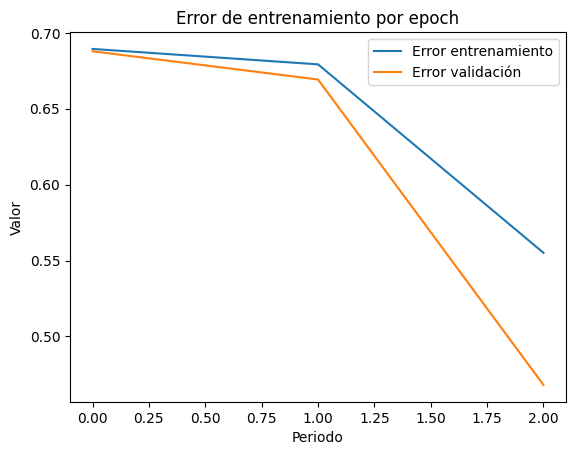

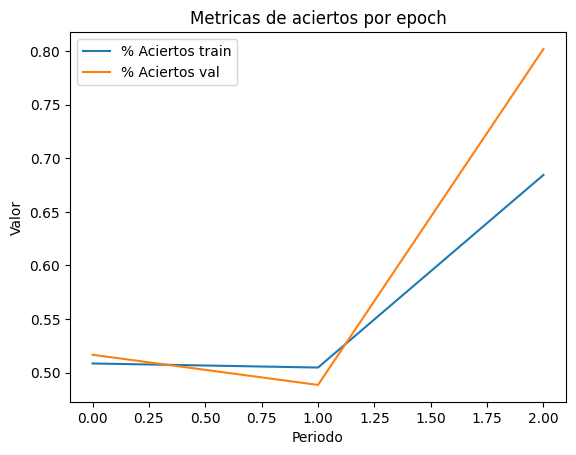

In [12]:
# Ver resultados en entrenamiento y validación
plt.plot(history.history["loss"], label="Error entrenamiento")
plt.plot(history.history["val_loss"], label="Error validación")
plt.title("Error de entrenamiento por epoch")
plt.xlabel("Periodo")
plt.ylabel("Valor")
plt.legend()
plt.show()

# De métricas de precisión
plt.plot(history.history["accuracy"], label="% Aciertos train")
plt.plot(history.history["val_accuracy"], label="% Aciertos val")
plt.title("Metricas de aciertos por epoch")
plt.xlabel("Periodo")
plt.ylabel("Valor")
plt.legend()
plt.show()



# Entrenando un modelo más complejo
![](https://drive.google.com/uc?id=1Es-jTfKtB7C5nDZuaZZbiyQPm-Cc3AQy)

La imagen de arriba es el modelo que vamos a crear.



La función `tf.keras.layers.Bidirectional` también se puede usar con una capa de RNN. Esto propaga el *input* hacia adelante y hacia atrás a través de la capa de la RNN y luego concatenada la salida final.

+ La ventaja principal de una RNN bidireccional es que la señal del principio del *input* no necesita ser procesada completamente en cada *timestep* para afectar la salida.
+ La desventaja principal de una RNN bidireccional es que no pueden fluir predicciones eficientemente mientras que las palabras están siendo añadidas al final.

5.    Luego de que la RNN convierte la secuencia a un único vector, las dos `layers.Dense` hacen un poco de procesamiento final y convierten este representación vectorial a un único *logito*  traducción que sirve como salida de clasificación.

El código para hacer esto es el siguiente:



In [41]:
modelo_bi = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use el masking para manejar las longitudes variables de las secuencias
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # Bidireccional LSTM
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

Compilar el modelo para configurar el proceso de entrenamiento:

In [42]:
modelo_bi.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [43]:
history_bi = modelo_bi.fit(train_dataset, epochs=3,
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/3
 43/782 ━━━━━━━━━━━━━━━━━━━━ 13:41 1s/step - accuracy: 0.4934 - loss: 0.6930

KeyboardInterrupt: 

Haga una predicción con otra oración. Si la predicción es mayor a 0.0, es una opinión positiva y sino es negativa.

## Apilar dos o más capas LSTM

Las capas recurrentes de Keras tienen dos modos disponibles que son controlados por el argumento `return_sequences` del constructor:

+ Si es `False`, devuelve solo la última salida de cada secuencia de entrada (un tensor 2D de dimensiones (batch_size, output_features)). Este es el predeterminado, usado en el modelo anterior.
+ Si es `True`, se devuelven todas las secuencias de salidas sucesivas de cada *timestep* (un tensor 3D de dimensiones `(batch_size, timesteps, output_features)`).

Así se ve el flujo de la información cuando se tiene `return_sequences=True`:

![](https://drive.google.com/uc?id=1E8in1oaj_xoFEeU_vsl6J4Ur78RYvgdR)

Lo interesante de usar una RNN con `return_sequences=True` es que la salida todavía tiene tres ejes, como la entrada, entonces puede ser pasado a otra capa de RNN, así:

In [51]:
model_bi_2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [52]:
model_bi_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [53]:
# Modelo con return_sequences = False
history = model_bi_2.fit(train_dataset, epochs=10,
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/10


KeyboardInterrupt: 

## Medición del rendimiento

Ahora, evaluemos el rendimiento de los modelos creados anteriormente.

NOTA: Esta sección es dada como un código inicial, hay partes que deben ser ajustadas por el/la estudiante para obtener los resultados deseados. Basarse en ejercicios de laboratorios anteriores.

In [16]:
test_loss, test_acc = modelo_base.evaluate(test_dataset)
print('Rendimiento del modelo:', test_acc, test_loss)


625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 73ms/step - accuracy: 0.7971 - loss: 0.4734
Rendimiento del modelo: 0.7973499894142151 0.47326919436454773


In [20]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
#modelos = [modelo_base, modelo_bi, model_bi_2]
modelos = [modelo_base]
X_test = []
y_test = []
for x, y in test_dataset:
  X_test.append(x.numpy())
  y_test.append(y.numpy())
for m in modelos:
  # Create confusion matrix
  predichos = np.where(m.predict(X_test) > 0.5, 1, 0) # X_test y y_test no existen, dimensionalidad diferente
  conf_matrix = confusion_matrix(y_test, predichos)

  # Plot confusion matrix using seaborn
  plt.figure(figsize=(5, 5))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicho')
  plt.ylabel('Real')
  plt.title('Matriz de confusión')
  plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


ValueError: Found input variables with inconsistent numbers of samples: [625, 32]

In [ ]:
# Classification report sklearn
from sklearn.metrics import classification_report
for idx, m in enumerate([modelo_base, modelo_bi, modelo_bi_2]):
  print("Model:", idx)
  # Create confusion matrix
  predichos = np.where(m.predict(X_test) > 0.5, 1, 0)
  print(classification_report(y_test, predichos))

# FINAL DEL LABORATORIO